In [1]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arixyt","key":"e649a7bc7401e4d8354650d6f006dcb0"}'}

In [2]:
import os
os.makedirs('~/.kaggle', exist_ok=True)
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset



Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 98% 651M/663M [00:06<00:00, 140MB/s]
100% 663M/663M [00:06<00:00, 111MB/s]


In [4]:
!unzip tuberculosis-tb-chest-xray-dataset.zip -d /content/tb_xray_dataset/

Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: /content/tb_xray_dataset/TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: /content/tb_xray

In [5]:
import os
dataset_dir = '/content/tb_xray_dataset/TB_Chest_Radiography_Database'
os.listdir(dataset_dir)

['README.md.txt',
 'Tuberculosis.metadata.xlsx',
 'Normal.metadata.xlsx',
 'Tuberculosis',
 'Normal']

In [6]:
# Create train, val, and test directories
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/train/normal
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/train/tuberculosis
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/val/normal
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/val/tuberculosis
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/test/normal
!mkdir -p /content/tb_xray_dataset/TB_Chest_Radiography_Database/test/tuberculosis

In [7]:
!pip install split-folders


In [8]:
import splitfolders  # To install: pip install split-folders

# Path to the dataset folder containing 'normal' and 'tuberculosis' images
input_folder = '/content/tb_xray_dataset/TB_Chest_Radiography_Database'

# Automatically create the split (80% training, 10% validation, 10% testing)
splitfolders.ratio(input_folder, output="/content/tb_xray_dataset",
                   seed=42, ratio=(.8, .1, .1), group_prefix=None)  # (.8, .1, .1) => 80% train, 10% val, 10% test


Copying files: 4200 files [00:02, 1832.59 files/s]


In [9]:
!rm -r /content/tb_xray_dataset/TB_Chest_Radiography_Database


In [10]:
import os

# Check the folder structure to confirm
for root, dirs, files in os.walk('/content/tb_xray_dataset'):
    print(root, len(files))


/content/tb_xray_dataset 0
/content/tb_xray_dataset/test 0
/content/tb_xray_dataset/test/test 0
/content/tb_xray_dataset/test/val 0
/content/tb_xray_dataset/test/train 0
/content/tb_xray_dataset/test/Tuberculosis 70
/content/tb_xray_dataset/test/Normal 350
/content/tb_xray_dataset/val 0
/content/tb_xray_dataset/val/test 0
/content/tb_xray_dataset/val/val 0
/content/tb_xray_dataset/val/train 0
/content/tb_xray_dataset/val/Tuberculosis 70
/content/tb_xray_dataset/val/Normal 350
/content/tb_xray_dataset/train 0
/content/tb_xray_dataset/train/test 0
/content/tb_xray_dataset/train/val 0
/content/tb_xray_dataset/train/train 0
/content/tb_xray_dataset/train/Tuberculosis 560
/content/tb_xray_dataset/train/Normal 2800


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,        # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,           # Apply shear transformation
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Random horizontal flip
    validation_split=0.2       # Split 20% for validation
)


# ImageDataGenerator for validation (no augmentation, just rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    '/content/tb_xray_dataset/train',    # Path to training directory
    target_size=(224, 224),              # Resize images to 224x224 for VGGNet
    batch_size=32,                       # Adjust batch size as needed
    class_mode='binary',                 # Binary classification (normal vs TB)
    color_mode='rgb',
    subset='training'                    # Training subset
)

# Validation data generator
validation_generator = validation_datagen.flow_from_directory(
    '/content/tb_xray_dataset/val',    # Path to validation directory (same as training)
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    subset='validation'                  # Validation subset
)

# ImageDataGenerator for test set (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    '/content/tb_xray_dataset/test',   # Path to test directory
    target_size=(224, 224),            # Resize images to 224x224
    batch_size=32,                     # Adjust batch size as needed
    class_mode='binary',               # Binary classification
    color_mode='rgb',                  # Use RGB images
    shuffle=False                      # Don't shuffle test data
)


Found 2688 images belonging to 5 classes.
Found 84 images belonging to 5 classes.
Found 420 images belonging to 5 classes.


In [20]:
for batch in train_generator:
    print(batch[0].shape)  # Print the shape of the images in the batch
    break  # Check the shape of the first batch


(32, 224, 224, 3)


In [21]:
from tensorflow.keras.applications import VGG16
# Load the pre-trained VGG16 model without the top classification layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout


# # Freeze all the layers in the pre-trained model
# for layer in vgg_model.layers:
#     layer.trainable = False

# Create a new model
model = Sequential()

# Add VGG16 as the base
model.add(vgg_model)

# Add custom layers for classification
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model before calling summary
model.build(input_shape=(None, 224, 224, 3))
# Print the model summary
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 21,137,729 (80.63 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Take one batch from the data generator and pass it through the model
sample_batch, sample_labels = next(train_generator)
print("Sample batch shape:", sample_batch.shape)

# Pass the batch through the model to check for issues
model_output = model.predict(sample_batch)
print("Model output shape:", model_output.shape)


Sample batch shape: (32, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
Model output shape: (32, 1)


In [24]:
import numpy as np

# Check if the data generator returns NaNs
sample_batch, sample_labels = next(train_generator)
print("Contains NaN in batch:", np.any(np.isnan(sample_batch)))
print("Contains NaN in labels:", np.any(np.isnan(sample_labels)))


Contains NaN in batch: False
Contains NaN in labels: False


In [25]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 71s 726ms/step - accuracy: 0.7609 - loss: 1.7575 - val_accuracy: 0.8438 - val_loss: 0.4305
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8000 - val_loss: 0.5056
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 79s 710ms/step - accuracy: 0.8254 - loss: 0.4815 - val_accuracy: 0.8594 - val_loss: 0.3895
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.6312
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 64s 706ms/step - accuracy: 0.8399 - loss: 0.3963 - val_accuracy: 0.8125 - val_loss: 0.4824
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9000 - val_loss: 0.3574
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 713ms/step - accuracy: 0.8228 - loss: 0.4772 - val_accuracy: 0.8438 - val_loss: 0.4315
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0

In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 525ms/step - accuracy: 0.9609 - loss: 0.2912
Test Accuracy: 83.33%


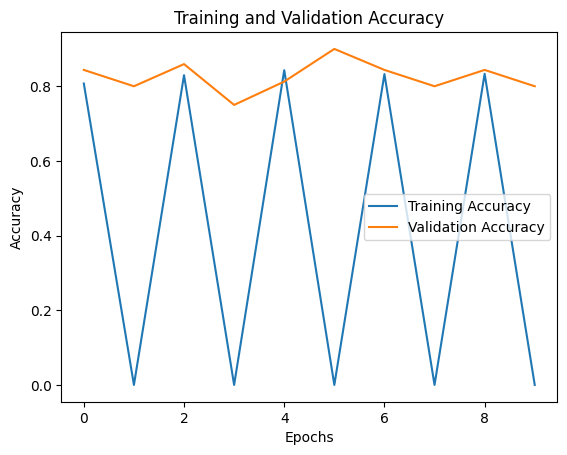

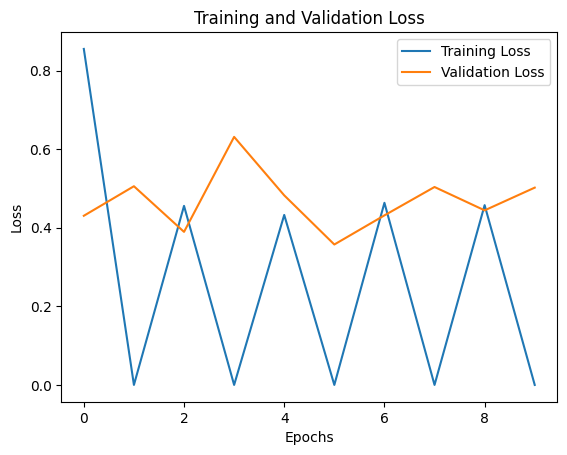

In [27]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
